In [1]:
#library(performance)
library(ggplot2)
library(olsrr)
library(eurostat)
options(width=160, repr.plot.width=11, repr.plot.height=7)   


Attaching package: ‘olsrr’


The following object is masked from ‘package:datasets’:

    rivers




# Cvičení 5: Lineární regrese

**Obsah cvičení:**
- příprava dat
- analýza závislosti regresoru a regresandu
- návrh modelu
- odhad parametrů modelu
- analýza parametrů a reziduí

## Modelování indexu cen nemovitostí

Zabývejme se problematikou modelování kvartálního HPI - House Price Indexu - indexu inflace v cenách nemovitostí. Detaily o indexech jsou na webu Eurostatu zde:
https://ec.europa.eu/eurostat/cache/metadata/en/prc_hpi_inx_esms.htm

**Data:**
- identifikátor: `prc_hpi_q`
- NUTS oblast: Německo (`DE`)
- jednotky: `I10_Q` (kvartální index přepočtený na rok 2015, který má hodnotu 100)
- podmnožina: `purchase == DW_NEW`

Data si nejprve stáhneme:

In [2]:
data <- get_eurostat('prc_hpi_q')
head(data)

Table prc_hpi_q cached at /tmp/RtmpfCWwhr/eurostat/6d0dc2b2cdc764fce16639f56d9f7605.rds



freq purchase unit  geo TIME_PERIOD values
1 Q    DW_EXST  I10_Q AT  2010-01-01   96.18
2 Q    DW_EXST  I10_Q AT  2010-04-01   99.11
3 Q    DW_EXST  I10_Q AT  2010-07-01  102.38
4 Q    DW_EXST  I10_Q AT  2010-10-01  102.32
5 Q    DW_EXST  I10_Q AT  2011-01-01  102.67
6 Q    DW_EXST  I10_Q AT  2011-04-01  105.68

Následně vybereme sloupce, které nás budou zajímat.

In [3]:
df <- data[data$geo == "DE",]
df <- df[df$unit == "I10_Q",]
df <- df[df$purchase == 'DW_NEW',]
df$freq <- NULL
df$geo <- NULL
df$unit <- NULL
df$purchase <- NULL
head(df)
tail(df)

TIME_PERIOD values
1 2005-01-01  90.5  
2 2005-04-01  88.1  
3 2005-07-01  89.9  
4 2005-10-01  88.8  
5 2006-01-01  88.9  
6 2006-04-01  87.0

TIME_PERIOD values
1 2022-04-01  178.2 
2 2022-07-01  179.9 
3 2022-10-01  177.4 
4 2023-01-01  174.8 
5 2023-04-01  172.8 
6 2023-07-01  171.9

Sloupec `TIME_PERIOD` nemá ideální podobu pro regresi. Potřebujeme jej vhodným způsobem transformovat. Jedna z variant je následující:

In [4]:
df$TIME_PERIOD = seq(2005, 2023.5, by=0.25)

Pohled na data napoví, jaký model bychom mohli uvažovat:

In [5]:
head(df)

TIME_PERIOD values
1 2005.00     90.5  
2 2005.25     88.1  
3 2005.50     89.9  
4 2005.75     88.8  
5 2006.00     88.9  
6 2006.25     87.0

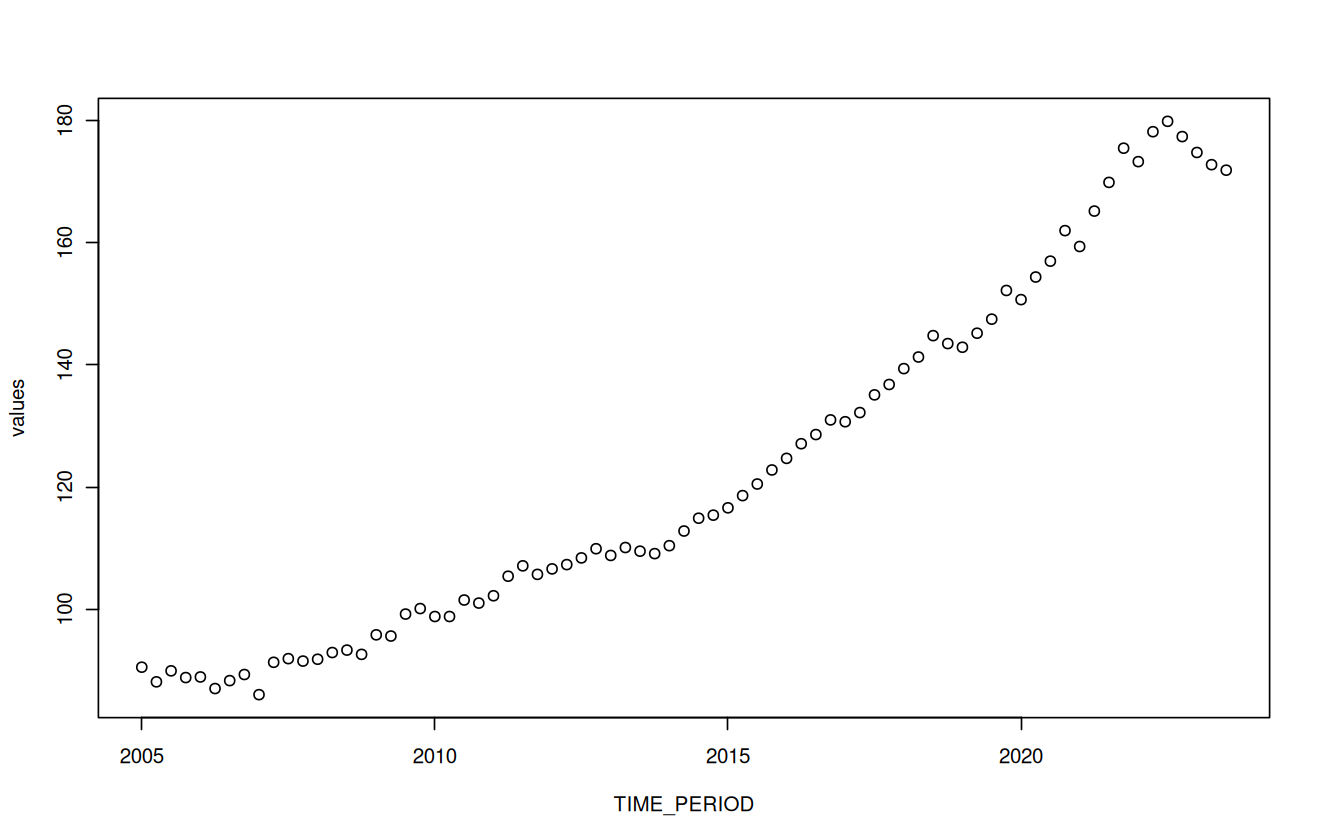

In [6]:
plot(df)

Jeden z prvních kroků může být pokusné vložení regresního polynomu do dat přímo v obrázku. Můžeme zkusit více různých modelů a sledovat, který lépe odpovídá datům.

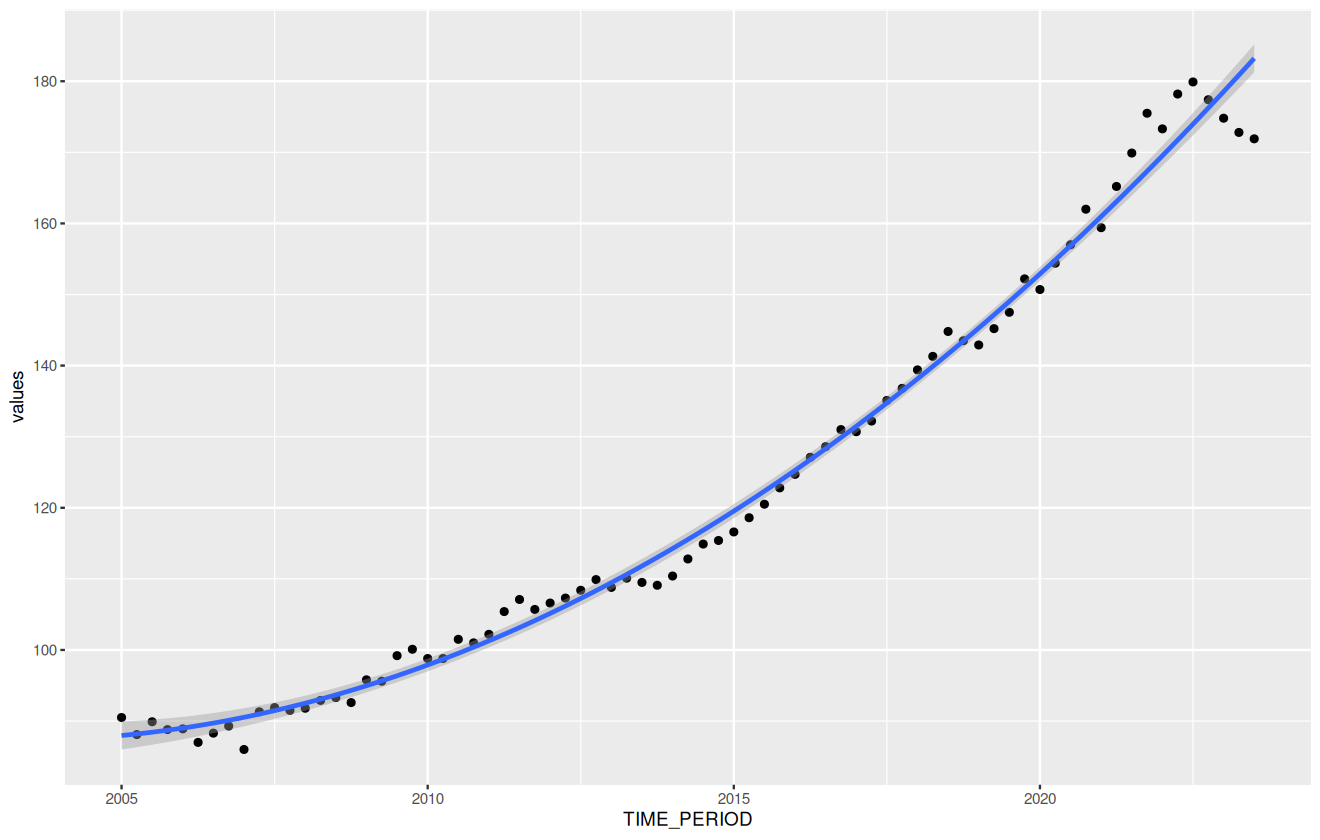

In [7]:
ggplot(df, aes(x=TIME_PERIOD, y=values)) +
    geom_point() +
    stat_smooth(method="lm", formula=y~x+I(x^2))

Máme-li vybraný model, nafitujeme jej. To znamená, odhadneme parametry modelu. Současně si můžeme připravit predikce pro pozdější vykreslení predikčního intervalu:

In [8]:
fit <- lm(values ~ TIME_PERIOD + I(TIME_PERIOD^2), data=df)
tmp <- predict(fit, interval="prediction")
df <- cbind(df, tmp)
head(df)

Warning message in predict.lm(fit, interval = "prediction"):
“predictions on current data refer to _future_ responses
”


TIME_PERIOD values fit      lwr      upr     
1 2005.00     90.5   87.96870 81.82193 94.11548
2 2005.25     88.1   88.18652 82.07198 94.30106
3 2005.50     89.9   88.43363 82.34844 94.51882
4 2005.75     88.8   88.71004 82.65146 94.76862
5 2006.00     88.9   89.01575 82.98117 95.05032
6 2006.25     87.0   89.35075 83.33772 95.36378

Dalším krokem je nutně vyhodnocení modelu. Mimo jiné sledujeme statistickou významnost jednotlivých koeficientů. Není-li koeficient významně odlišný od nuly, můžeme související regresor v modelu vynechat. Dále sledujeme $R^2$ a jeho adjustovanou variantu a $F$-test nezávislosti regresandu na regresorech.

In [9]:
summary(fit)


Call:
lm(formula = values ~ TIME_PERIOD + I(TIME_PERIOD^2), data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-11.319  -1.552   0.090   1.336   8.161 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       9.407e+05  5.226e+04    18.0   <2e-16 ***
TIME_PERIOD      -9.390e+02  5.189e+01   -18.1   <2e-16 ***
I(TIME_PERIOD^2)  2.344e-01  1.288e-02    18.2   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.922 on 72 degrees of freedom
Multiple R-squared:   0.99,	Adjusted R-squared:  0.9898 
F-statistic:  3577 on 2 and 72 DF,  p-value: < 2.2e-16


- `Residuals` - důležité míry polohy reziduí (chyb regrese)
- `Coefficients` - `(Intercept)` je odhad $\hat{\beta}_0$, `wt` je odhad $\hat{\beta}_1$, jednotlivé sloupce mají následující význam: 
    - `Estimate` je hodnota bodového odhadu příslušného koeficientu,
    - `Std. Error` - směrodatná odchylka odhadu
    - `t value` - hodnota testové statistiky
    - `Pr(>|t|)` - p-hodnota testu o nulovosti příslušného koeficientu
- `Residual standard error` - $S_e/(n-k)$ kde $(n-k)$ je počet stupňů volnosti
- `Multiple R-squared` - koeficient determinace $R^2$
- `Adjusted R-squared` - adjustovaný koeficient determinace $R^2$
- `F-statistic` - F-statistika, stupně volnosti a p-hodnota testu, že všechny koeficienty jsou rovny nule.

Jeví-li se model jako vhodný, zajímá nás, jak dobře interpoluje data. Iterpretujte graf!

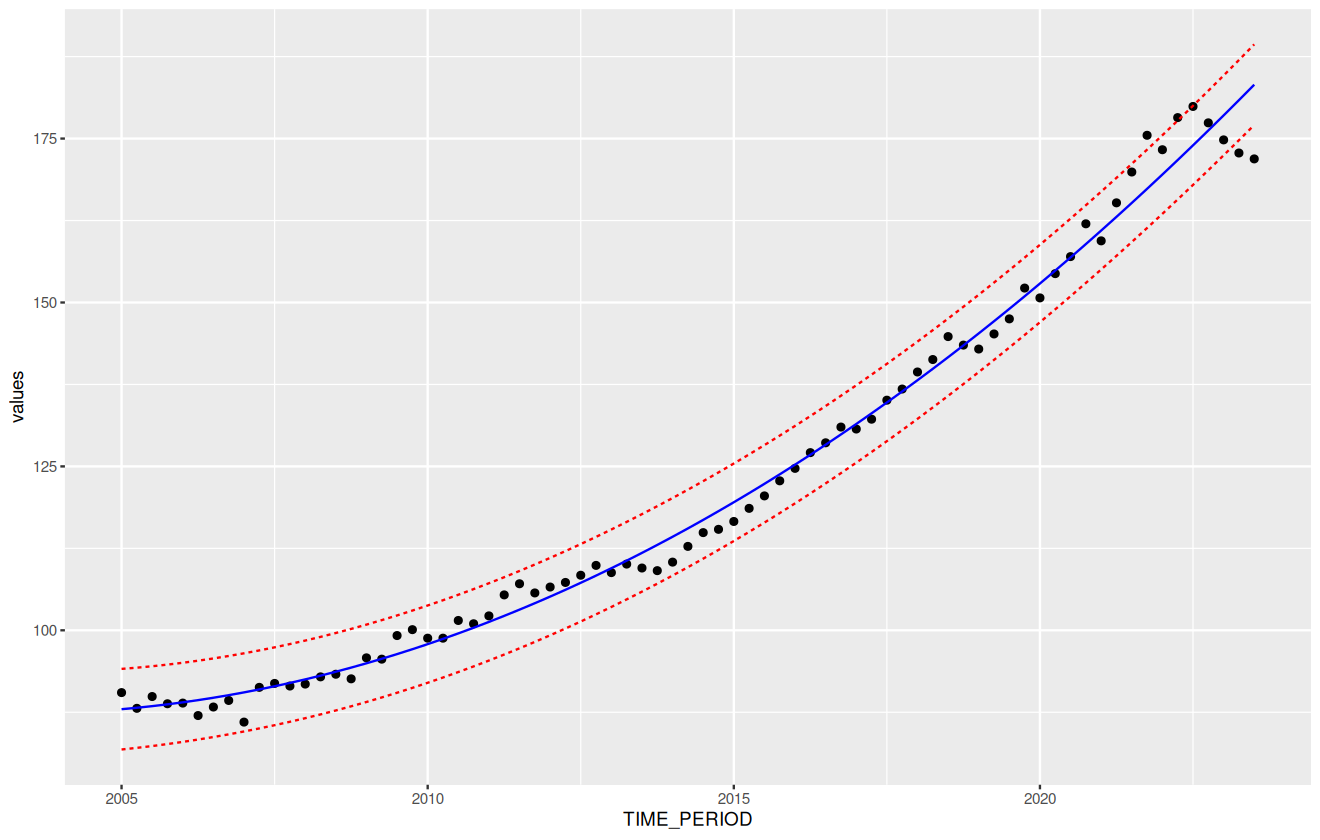

In [10]:
ggplot(df, aes(x=TIME_PERIOD, y=values)) +
    geom_point() +
    geom_line(aes(y=fit), color="blue") +
    geom_line(aes(y=lwr), color = "red", linetype = "dashed") +
    geom_line(aes(y=upr), color = "red", linetype = "dashed")

Nyní je na řadě analýza reziduí. V grafu reziduí nás zajímá, zda jsou data symetricky rozložena okolo nuly a do jaké míry je přímka, která je vysvětluje, odchylná od vodorovné osy. Analyzujeme, zda rezidua mají nějaký vzor, indikující nedostatečné vysvětlení dat modelem (viz přednáška).

Pokud je nějaký vzor přítomen, často můžeme vysledovat autokorelaci mezi rezidui. To je typické pro časové řady. Použijeme vhodný test.

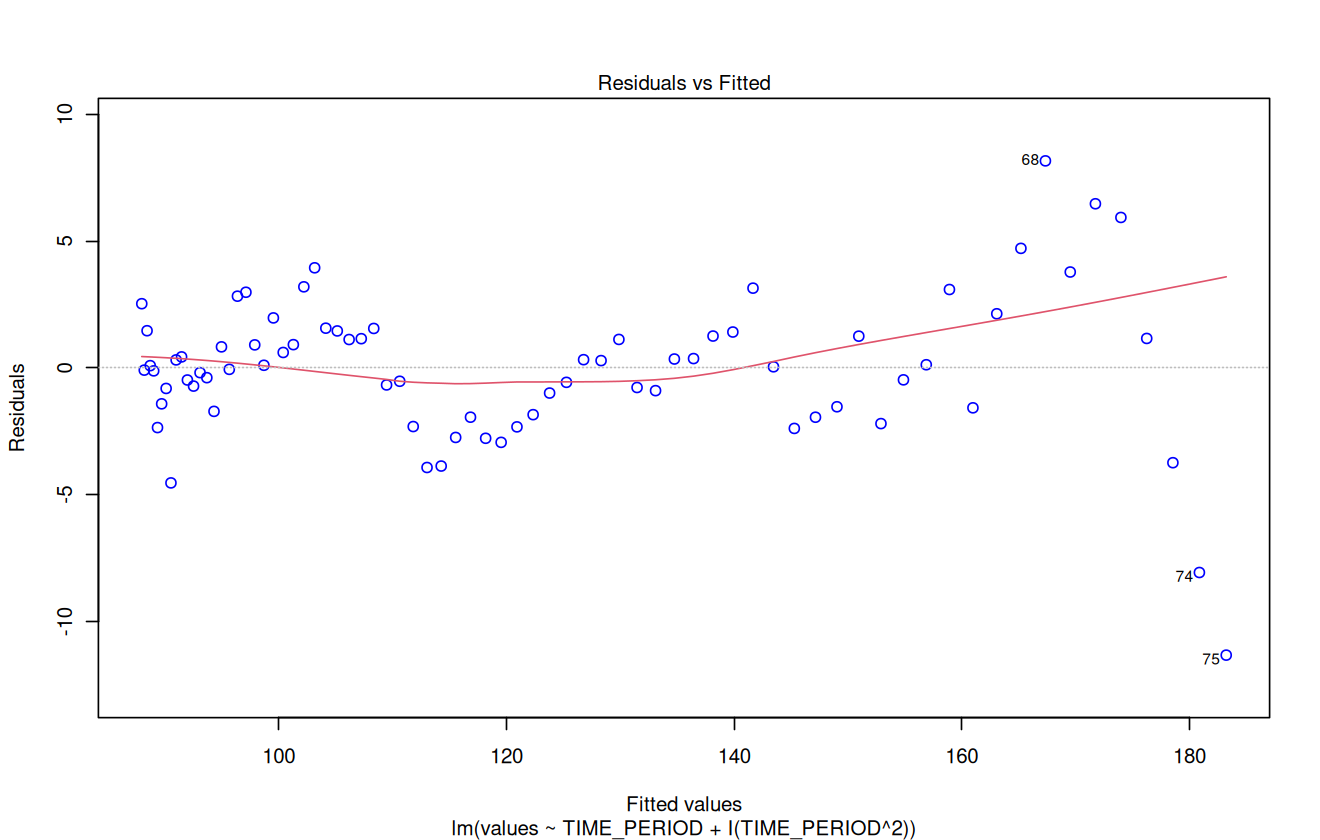

In [11]:
plot(fit, which=1, col=c("blue"))

In [12]:
ols_test_correlation(fit)

[1] 0.9642882

Zajímá nás dále normalita reziduí. Zjišťujeme ji pomocí Q-Q grafu a testujeme vhodným testem (jakým?).

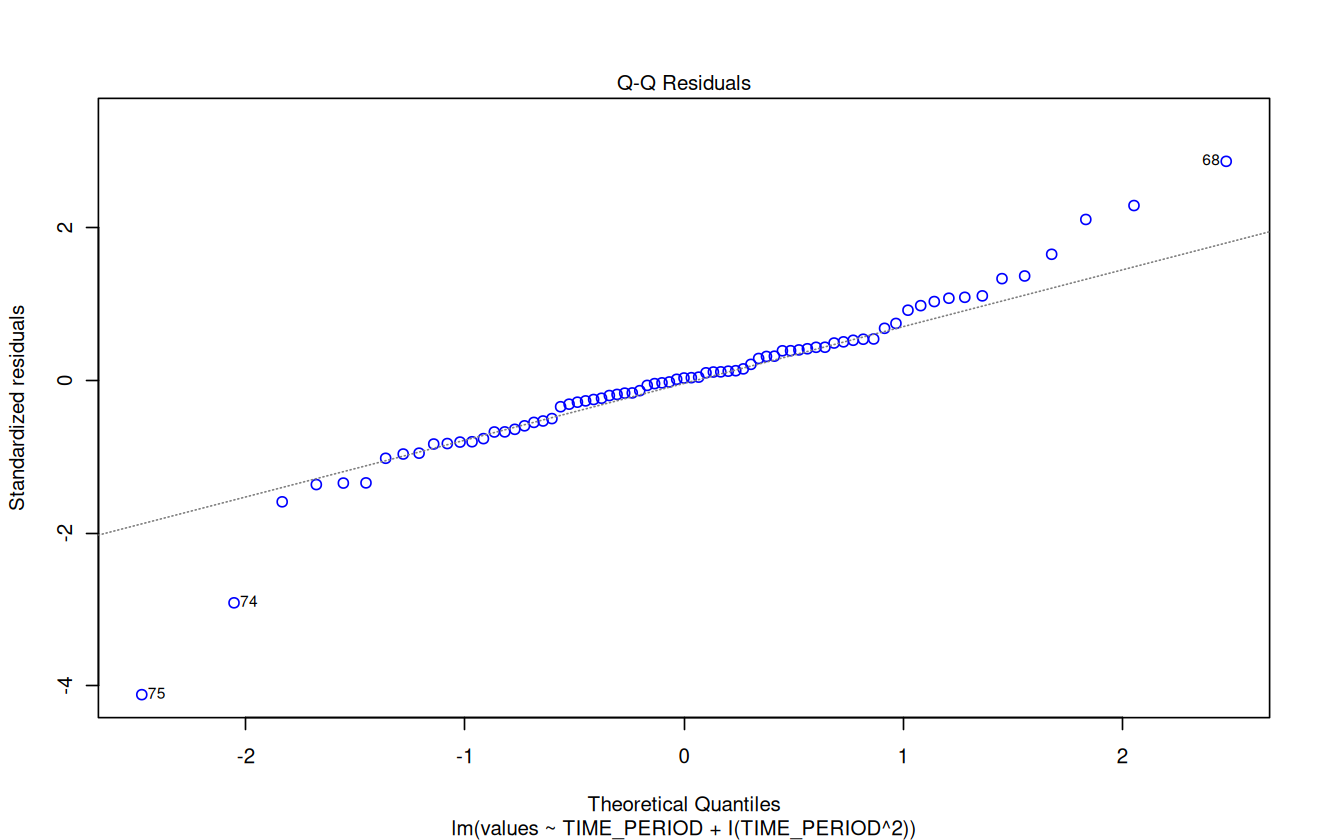

In [13]:
plot(fit, which=2, col=c("blue"))

In [14]:
ols_test_normality(fit)

-----------------------------------------------
       Test             Statistic       pvalue  
-----------------------------------------------
Shapiro-Wilk              0.9417         0.0018 
Kolmogorov-Smirnov        0.1067         0.3368 
Cramer-von Mises          4.8664         0.0000 
Anderson-Darling          1.0745         0.0076 
-----------------------------------------------

Problematickým, leč vcelku běžným jevem je heteroskedasticita šumu, která se projeví i na heteroskedasticitě reziduí. [Heteroskedasticita](https://en.wikipedia.org/wiki/Homoscedasticity_and_heteroscedasticity) znamená proměnnost variance (např. v závislosti na čase), opakem je [homoskedasticita](https://en.wikipedia.org/wiki/Homoscedasticity_and_heteroscedasticity). Přítomnost výrazně heteroskedastického šumu typicky vyžaduje vhodnou transformaci dat pro stabilizaci rozptylu.

V grafu níže sledujeme, zda jsou body rozloženy symetricky okolo červené křivky.

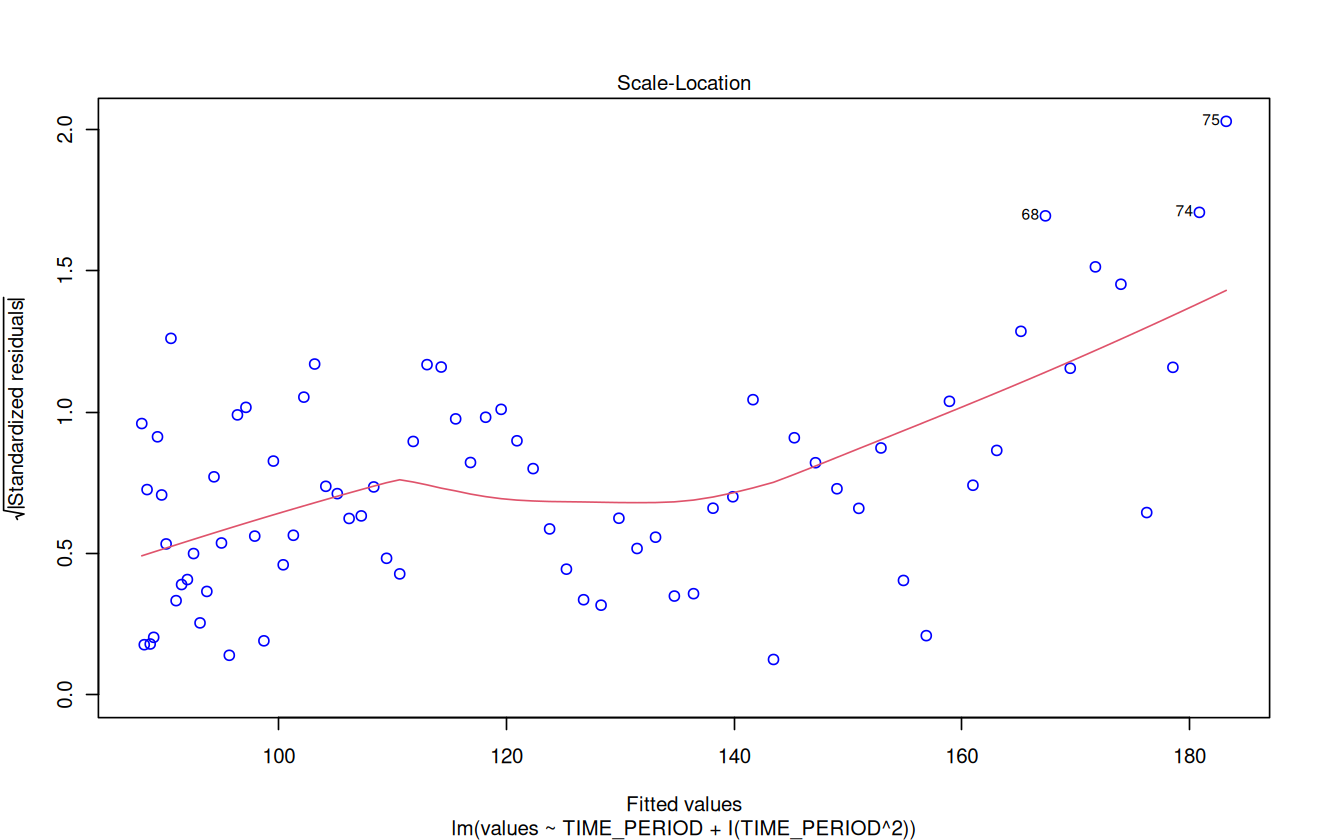

In [15]:
plot(fit, which=3, col=c("blue"))

In [16]:
ols_test_breusch_pagan(fit)


 Breusch Pagan Test for Heteroskedasticity
 -----------------------------------------
 Ho: the variance is constant            
 Ha: the variance is not constant        

               Data                
 ----------------------------------
 Response : values 
 Variables: fitted values of values 

         Test Summary           
 -------------------------------
 DF            =    1 
 Chi2          =    45.32946 
 Prob > Chi2   =    1.665256e-11 

Dalším krokem může být vyšetření [Cookovy vzdálenosti](https://en.wikipedia.org/wiki/Cook%27s_distance). Ta indikuje míru vlivu jednotlivých pozorování na hodnoty odhadů parametrů modelu. Dokážeme tak detekovat odlehlá pozorování (outliery), která mají zásadní vliv a jejichž vyfiltrování by mohlo zlepšit vlastnosti modelu.

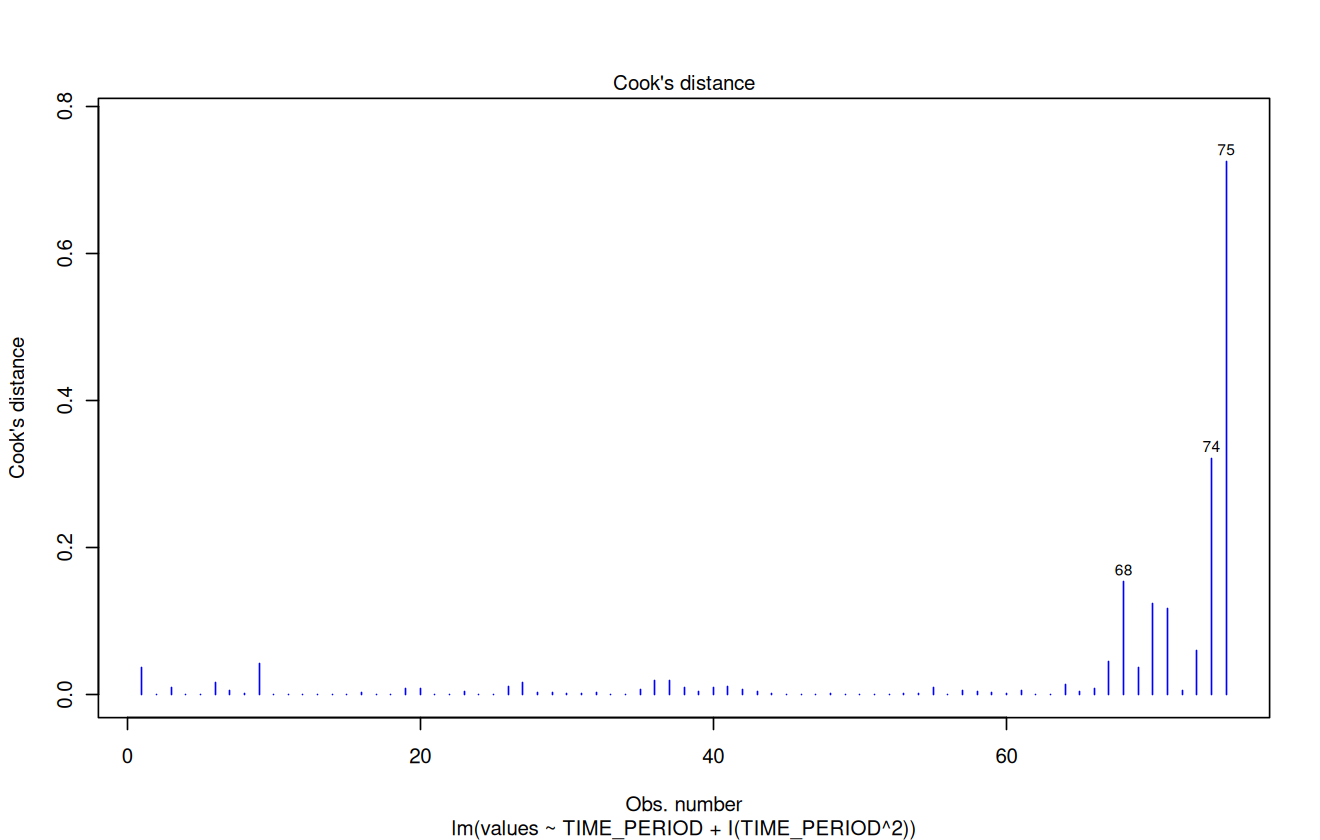

In [17]:
plot(fit, which=4, col=c("blue"))

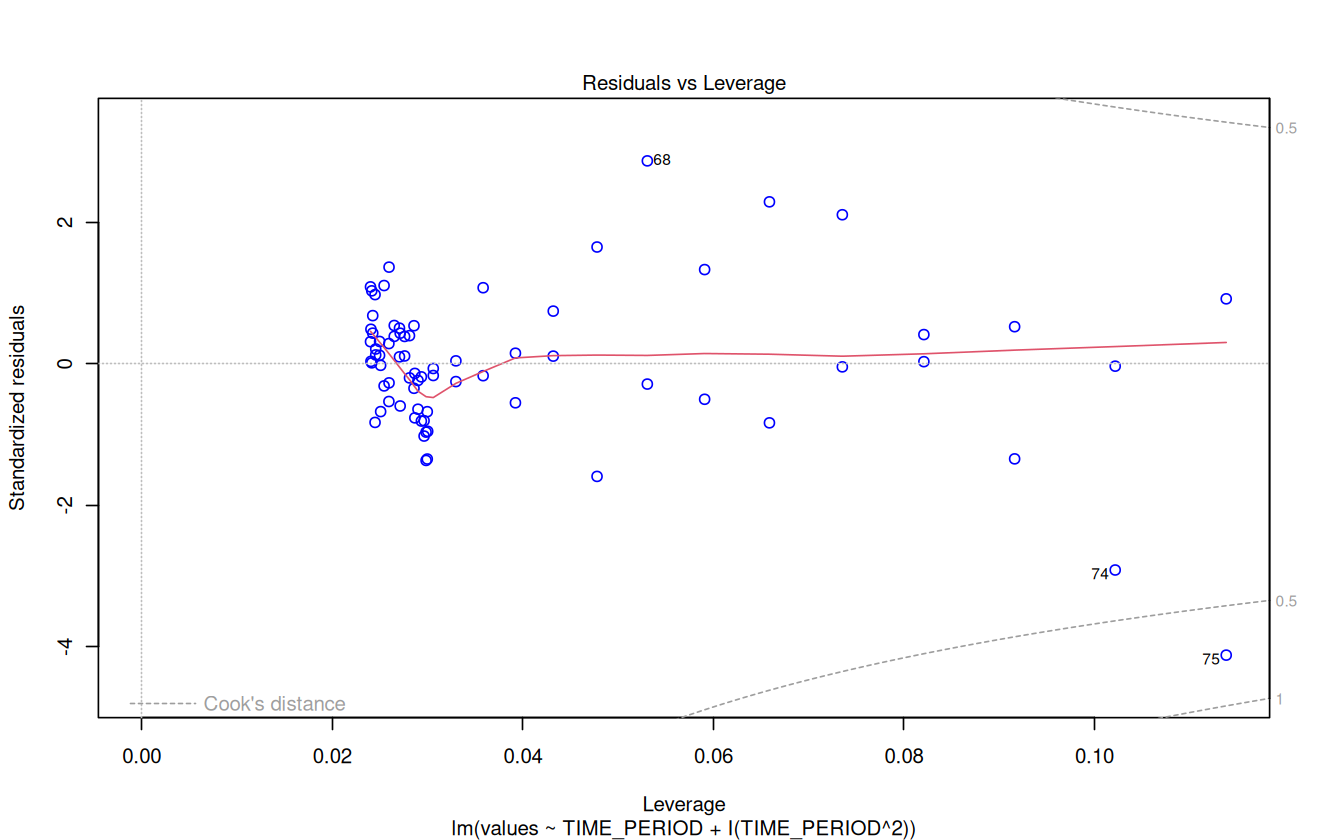

In [18]:
plot(fit, which=5, col=c("blue"))

## Predikce budoucích hodnot

Nyní zkusíme predikovat budoucí hodnoty. Nejprve si ověříme, kde končí stávající datová sada.

In [19]:
tail(df)

TIME_PERIOD values fit      lwr      upr     
70 2022.25     178.2  171.7298 165.7167 177.7428
71 2022.50     179.9  173.9691 167.9345 180.0037
72 2022.75     177.4  176.2377 170.1792 182.2963
73 2023.00     174.8  178.5357 172.4505 184.6209
74 2023.25     172.8  180.8629 174.7484 186.9775
75 2023.50     171.9  183.2194 177.0727 189.3662

Potřebujeme vytvořit nový data.frame, který bude obsahovat budoucí časové okamžiky. Není od věci zachovat systém v pořadí. Dosud byly nejnovější data nahoře, proto je rozumné mít podobně seřazené i budoucí predikce.

In [20]:
future <- data.frame(TIME_PERIOD=seq(2023.75, 2025, by=.25))

Funkci `predict()` již známe. Předáme jí tedy data. Jelikož budeme později vykreslovat data stávající i budoucí predikovaná a budeme spojovat příslušné data.framy, připravíme si predikce tak, aby byly kompatibilní se stávajícími daty.

In [21]:
fcast <- predict(fit, future, interval='prediction')
future <- cbind(future, fcast)
future$values <- future$fit
head(future)

TIME_PERIOD fit      lwr      upr      values  
1 2023.75     185.6053 179.4232 191.7873 185.6053
2 2024.00     188.0204 181.7999 194.2408 188.0204
3 2024.25     190.4648 184.2027 196.7270 190.4648
4 2024.50     192.9385 186.6313 199.2458 192.9385
5 2024.75     195.4415 189.0856 201.7975 195.4415
6 2025.00     197.9739 191.5656 204.3821 197.9739

Data můžeme nyní spojit:

In [22]:
df.fcast <- rbind(future, df)
head(df.fcast)

TIME_PERIOD fit      lwr      upr      values  
1 2023.75     185.6053 179.4232 191.7873 185.6053
2 2024.00     188.0204 181.7999 194.2408 188.0204
3 2024.25     190.4648 184.2027 196.7270 190.4648
4 2024.50     192.9385 186.6313 199.2458 192.9385
5 2024.75     195.4415 189.0856 201.7975 195.4415
6 2025.00     197.9739 191.5656 204.3821 197.9739

Jak vypadají data, predikční intervaly a budoucí predikované hodnoty ukazuje následující obrázek. Jak by se vyvíjely predikční intervaly do delší budoucnosti? (ověřte!)

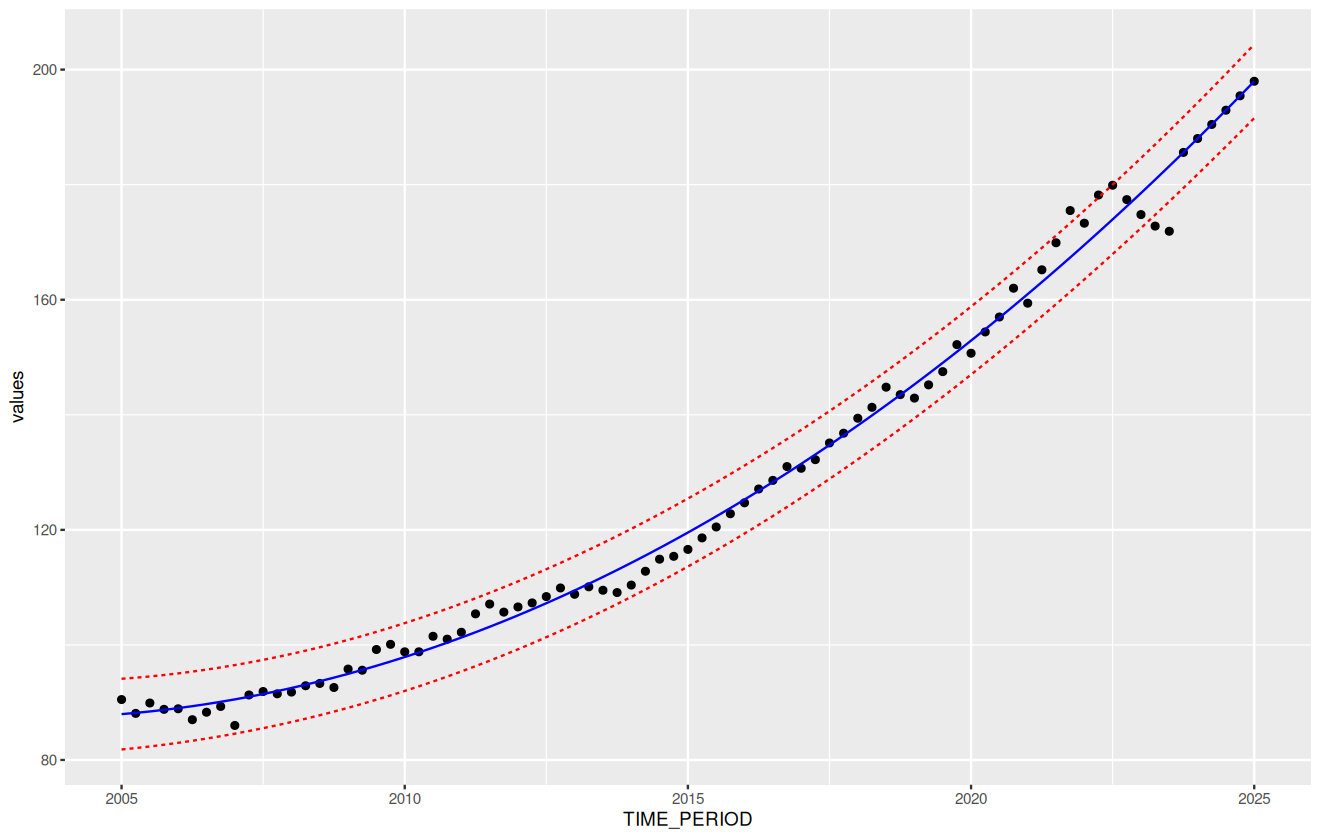

In [23]:
ggplot(df.fcast, aes(x=TIME_PERIOD, y=values)) +
    geom_point() +
    geom_line(aes(y=fit), color = "blue") +
    geom_line(aes(y=lwr), color = "red", linetype = "dashed") +
    geom_line(aes(y=upr), color = "red", linetype = "dashed")

Samostatně můžete zkusit vynechat problematická měření a vysledovat, co to udělá s kvalitou modelu.

---
---